In [101]:
import torch
import torch.utils
import torch.nn as nn
import torchvision as tv

import numpy as np
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(std=(0.5,), mean=(0.5,)),
])

In [36]:
mnist = tv.datasets.MNIST(root=".", download=True, transform=my_transforms) 
mnist_train, mnist_test = torch.utils.data.random_split(mnist, [0.8, 0.2])
len(mnist_train), len(mnist_test)

(48000, 12000)

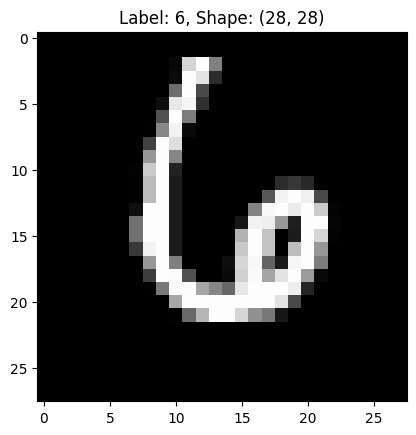

In [35]:
img = mnist_train[0][0][0].numpy()
plt.title(f"Label: {mnist_train[0][1]}, Shape: {img.shape}")
plt.imshow(img, cmap="gray")
plt.show()

In [42]:
bath_size = 128
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=bath_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=bath_size, shuffle=False)

In [41]:
next(iter(train_loader))[0].shape

torch.Size([128, 1, 28, 28])

In [114]:
class MNISTClassifier(nn.Module):
    def __init__(self, hidden_features=1024):
        super(MNISTClassifier, self).__init__()
        self.linear1 = nn.Linear(in_features=1*28*28, out_features=hidden_features)
        self.linear2 = nn.Linear(in_features=hidden_features, out_features=int(hidden_features/2))
        self.linear3 = nn.Linear(in_features=int(hidden_features/2), out_features=10)

        self.act1 = nn.ReLU()
        self.act2 = nn.Softmax()
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.drop(x)
        x = self.linear3(x)
        out = self.act2(x)
        return out
    

model = MNISTClassifier(hidden_features=1024).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [115]:
EPOCHS = 15
train_accuracy = []
test_accuracy = []


for epoch in range(EPOCHS):
    model.train()
    train_progressbar = tqdm(train_loader, desc=f"Epoch: [{epoch+1}/{EPOCHS}]")
    for idx, (images, labels) in enumerate(train_progressbar):
        optim.zero_grad()
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28*28)
        predict = model(images)
        loss = loss_fn(predict, labels)
        loss.backward()
        optim.step()

        train_progressbar.set_description(f"TRAIN Epoch: [{epoch+1}/{EPOCHS}] Loss: {round(loss.item(), 4)} Accuracy: {round(np.mean(train_accuracy), 4)}%")
    train_accuracy.append((np.mean(accuracy_score(predict.argmax(dim=1).detach().numpy(), labels.detach().numpy()))))

    
    with torch.no_grad():
        model.eval()
        test_progressbar = tqdm(test_loader, desc=f"Epoch: [{epoch+1}/{EPOCHS}]")
        for idx, (images, labels) in enumerate(test_progressbar):
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            predict = model(images)
            
            test_progressbar.set_description(f"TEST Epoch: [{epoch+1}/{EPOCHS}] Loss: {round(loss.item(), 4)} Accuracy: {round(np.mean(test_accuracy), 4)}%")
        test_accuracy.append((np.mean(accuracy_score(predict.argmax(dim=1).detach().numpy(), labels.detach().numpy()))))
            

TEST Epoch: [1/15] Loss: 1.5686 Accuracy: nan%: 100%|██████████| 94/94 [00:01<00:00, 63.97it/s]
TRAIN Epoch: [2/15] Loss: 1.5095 Accuracy: 0.8984%: 100%|██████████| 375/375 [00:08<00:00, 45.50it/s]
TEST Epoch: [2/15] Loss: 1.5095 Accuracy: 0.8958%: 100%|██████████| 94/94 [00:01<00:00, 65.41it/s]
TRAIN Epoch: [3/15] Loss: 1.5638 Accuracy: 0.9258%: 100%|██████████| 375/375 [00:08<00:00, 45.29it/s]
TEST Epoch: [3/15] Loss: 1.5638 Accuracy: 0.9062%: 100%|██████████| 94/94 [00:01<00:00, 64.97it/s]
TRAIN Epoch: [4/15] Loss: 1.5072 Accuracy: 0.9167%: 100%|██████████| 375/375 [00:08<00:00, 45.40it/s]
TEST Epoch: [4/15] Loss: 1.5072 Accuracy: 0.9097%: 100%|██████████| 94/94 [00:01<00:00, 63.73it/s]
TRAIN Epoch: [5/15] Loss: 1.4965 Accuracy: 0.9277%: 100%|██████████| 375/375 [00:09<00:00, 40.03it/s]
TEST Epoch: [5/15] Loss: 1.4965 Accuracy: 0.9141%: 100%|██████████| 94/94 [00:01<00:00, 54.64it/s]
TRAIN Epoch: [6/15] Loss: 1.4929 Accuracy: 0.9359%: 100%|██████████| 375/375 [00:10<00:00, 37.39it/s

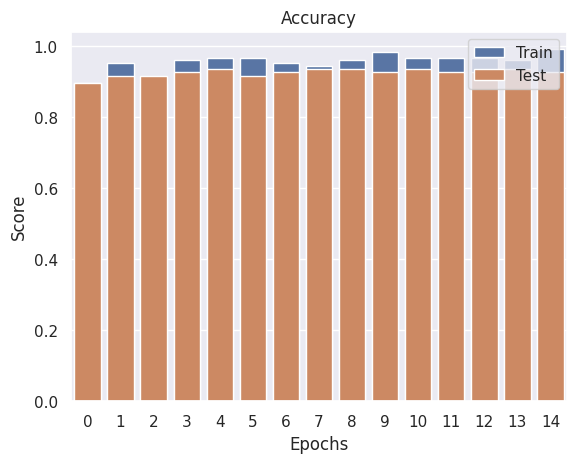

In [128]:
plt.title("Accuracy")
sns.barplot(train_accuracy, label="Train")
sns.barplot(test_accuracy, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()